# LGBM Model
* RNN was far too slow and hence infeasible given the time limit I am constrained within
* So going to use an LGBM

# Misc / setting up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import datetime
from IPython.display import display
from pprint import pprint
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold
import time
from sklearn import preprocessing
import seaborn as sns

In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf

In [2]:
import random
SEED = 137
random.seed(SEED)

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# loading the data

In [4]:
df_train = pd.read_pickle("../Data/Prepared_Data/supervised/consumption_all.pkl")
display(df_train)
df_preds = pd.read_pickle("../Data/Prepared_Data/supervised/consumption_all_preds.pkl")
display(df_preds)

,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,semi_detached,terraced,energy n-7,energy n-6,energy n-5,energy n-4,energy n-3,energy n-2,energy n-1,meter_reading
0,0x240e5e22734a44a174b7dabcf1ea00d70d9ec168,0,0,0,0,0,0,0,0,0,...,1.0,0.0,11.805677,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
1,0x2ce3d582a1316db5bcfe405cbd6070268944778e,0,0,0,0,0,0,0,0,0,...,1.0,0.0,11.805677,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
2,0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471,0,0,0,0,0,0,0,0,0,...,1.0,0.0,11.805677,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
3,0x391e6c2169c27de797ccbdf2d623365da28a6d3d,0,0,0,0,0,0,0,0,0,...,1.0,0.0,11.805677,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
4,0x423fa805ddb0cba9bdb4460f9a78540287eefd0e,0,0,0,0,0,0,0,0,0,...,1.0,0.0,11.805677,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617640,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,21.999000,26.232000,14.036000,15.990000,15.550500,15.111000,16.506000,18.758500
617641,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,26.232000,14.036000,15.990000,15.550500,15.111000,16.506000,18.758500,21.011000
617642,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,14.036000,15.990000,15.550500,15.111000,16.506000,18.758500,21.011000,19.204000
617643,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,15.990000,15.550500,15.111000,16.506000,18.758500,21.011000,19.204000,17.397000


,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,semi_detached,terraced,energy n-7,energy n-6,energy n-5,energy n-4,energy n-3,energy n-2,energy n-1,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# formatting the df's

In [5]:
#replacing nans with 0 so we can aggregate up the OOF predictions
df_preds["meter_reading"] = df_preds["meter_reading"].fillna(0) 
#dropping the "energy n-k" columns as they are needed for 3D RNN input not 2D LGBM input
df_preds = df_preds.drop(["energy n-7","energy n-6","energy n-5","energy n-4","energy n-3","energy n-2","energy n-1"], axis=1)
df_train = df_train.drop(["energy n-7","energy n-6","energy n-5","energy n-4","energy n-3","energy n-2","energy n-1"], axis=1)

display(df_train)
display(df_preds)

,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0x240e5e22734a44a174b7dabcf1ea00d70d9ec168,0,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
1,0x2ce3d582a1316db5bcfe405cbd6070268944778e,0,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
2,0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471,0,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
3,0x391e6c2169c27de797ccbdf2d623365da28a6d3d,0,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
4,0x423fa805ddb0cba9bdb4460f9a78540287eefd0e,0,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617640,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,18.758500
617641,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,21.011000
617642,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,19.204000
617643,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,17.397000


,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,0


# Ordinally encoding the ID's
* One hot / binary encoding can actually worsen performance of DT based algorithms
* and LGBM supports categorical values; so no need to use the binary encoded meter_id which we planned for the RNN
* Hence I will also now encode the ID ordinally and experiment with both to see which gives the best performing results

In [6]:
#ordinally encoding id's
le = preprocessing.LabelEncoder()
le.fit(df_train["meter_id"])

#ordinally encoding with same encoder so will encode the same
df_train.insert(1, "meter_id_ord", le.transform(df_train["meter_id"]))
df_preds.insert(1, "meter_id_ord", le.transform(df_preds["meter_id"]))

display(df_train)
display(df_preds)

,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0x240e5e22734a44a174b7dabcf1ea00d70d9ec168,425,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
1,0x2ce3d582a1316db5bcfe405cbd6070268944778e,542,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
2,0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471,585,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
3,0x391e6c2169c27de797ccbdf2d623365da28a6d3d,688,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
4,0x423fa805ddb0cba9bdb4460f9a78540287eefd0e,793,0,0,0,0,0,0,0,0,...,0.841254,1,0,3.0,semi_detached_house,0.0,0.0,1.0,0.0,11.881495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617640,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,18.758500
617641,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,21.011000
617642,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,19.204000
617643,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,17.397000


,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,1,1,3.0,detached_house,1.0,0.0,0.0,0.0,0


# Ordinally encoding the dwelling_type
* same reasons for replacing the binary encoded meter_id with ordinal encoding; going to replace one hot encodede dwelling type with ordinal encoding

In [7]:
#ordinally encoding dwelling_type
le = preprocessing.LabelEncoder()
le.fit(df_train["dwelling_type"])

#ordinally encoding with same encoder so will encode the same
df_train.insert(27, "dwelling_type_ord", le.transform(df_train["dwelling_type"]))
df_preds.insert(27, "dwelling_type_ord", le.transform(df_preds["dwelling_type"]))

display(df_train)
display(df_preds)

,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,is_weekend,energy_cluster,num_bedrooms,dwelling_type,dwelling_type_ord,detached,flat,semi_detached,terraced,meter_reading
0,0x240e5e22734a44a174b7dabcf1ea00d70d9ec168,425,0,0,0,0,0,0,0,0,...,1,0,3.0,semi_detached_house,3,0.0,0.0,1.0,0.0,11.881495
1,0x2ce3d582a1316db5bcfe405cbd6070268944778e,542,0,0,0,0,0,0,0,0,...,1,0,3.0,semi_detached_house,3,0.0,0.0,1.0,0.0,11.881495
2,0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471,585,0,0,0,0,0,0,0,0,...,1,0,3.0,semi_detached_house,3,0.0,0.0,1.0,0.0,11.881495
3,0x391e6c2169c27de797ccbdf2d623365da28a6d3d,688,0,0,0,0,0,0,0,0,...,1,0,3.0,semi_detached_house,3,0.0,0.0,1.0,0.0,11.881495
4,0x423fa805ddb0cba9bdb4460f9a78540287eefd0e,793,0,0,0,0,0,0,0,0,...,1,0,3.0,semi_detached_house,3,0.0,0.0,1.0,0.0,11.881495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617640,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,18.758500
617641,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,21.011000
617642,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,19.204000
617643,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,17.397000


,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,is_weekend,energy_cluster,num_bedrooms,dwelling_type,dwelling_type_ord,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,0
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,0
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,0
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,1,3.0,detached_house,1,1.0,0.0,0.0,0.0,0


# SKF-CV for training the LGBM
* Using skf on df_train by meter_id with 3 folds
    * Meaning for each iteration we use 2/3 of each meters data for training and 1/3 of each meters data for validating
* using out of fold predictions, making predictions on each fold and aggregating them together for the final prediction

* evaluates the model via OOF predictions made on the held out set on each fold
* this score is returned and along with the 3 models
* genetic algorithm hyper parameter tuning will then be used to find the LGBM hyper param config with the best val score and this will then be used to make predictions using the model which has the best validation score

In [41]:
import warnings
warnings.filterwarnings("ignore")

#function for running the cross fold
    #args:
        #disp_fold_info = True if we want to print info for each fold
        #disp_end_info = True if we want to display evaluation info at the end
        #SEED = random seed used for fair repeatability
        #num_folds = number of folds in skf (pretty certain going to keep this at 3 )
        #df_train = training dataframe
        #y_col = the name of the label we want to predict (meter_reading)
        #X_cols = the name of the feature columns we are using
        #X_cat = the name of these features which are categorical
        #params = hyper params for the LGBM model
    #returns:
        #time_of_execution = how long it took to train the model on all folds; will be used as a point of comparison
        #valid_score = MAE calculated using the Out-of-Fold Predictions on the df_train, used for hyper-param tuning
        #lgbm_models = array of the different lgbm_models
        
def run_lgbm_skf_cv(disp_fold_info, disp_end_info, SEED, num_folds, df_train, y_col, X_cols, X_cat, params):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = SEED) # defining the SKF algorithm

    lgbm_models = []
    start_time = time.time()
    fold_iter=1
    #running the startified kfold, splitting df_train by meter_id, so we use 2/3 of each meters reading for training
    for train_index, valid_index in skf.split(df_train, df_train["meter_id"]):

        print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Fold {fold_iter}{color.END}")
        
        #splitting into the features and labels for the train and valid folds
        X_train, X_valid = df_train.loc[train_index, X_cols], df_train.loc[valid_index, X_cols]
        y_train, y_valid = df_train.loc[train_index, y_col], df_train.loc[valid_index, y_col]
        
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}X_train{color.END}")
            display(X_train.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}y_train{color.END}")
            display(y_train.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}X_valid{color.END}")
            display(X_valid.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}y_valid{color.END}")
            display(y_valid.head(5))
            
        print(f"{color.CYAN}{color.UNDERLINE}Training the LGBM{color.END}")
        #instantiating a lgbm regressor with our params
        lgbm_model = lgbm.LGBMRegressor(**params)
        #fitting the lgbm model on the 2/3 train and evaluating on the 1/3 valid
        #printing details every 1000 iters + stopping if no improvement made in 250 iters
        lgbm_model.fit(X_train, y_train,
                       eval_set=[(X_valid, y_valid)],
                       categorical_feature=X_cat,
                       verbose=3333,
                       early_stopping_rounds=250)
        
        #saving the OOF prediction for the held out rows (valid rows from df_train) from the lgbm model with the best performing intrinisic parmams 
        oof_valid = lgbm_model.predict(X_valid, num_iteration=lgbm_model.best_iteration_) # making prediction on the held out rows, X_valid
        df_train.loc[valid_index, "oof"] = oof_valid #storing the oof rows 
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}df_train OOF predictions{color.END}")
            display(df_train.loc[valid_index, ["meter_id","oof"]].head(5))
               
        #appending this lgbm
        lgbm_models.append(lgbm_model)
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}lgbm_models size{color.END}: {len(lgbm_models)}")
            
        fold_iter+=1
        
    if(disp_end_info):
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}training set OOF preds vs true{color.END}")
        display(df_train[["meter_id","date","meter_reading","oof"]])
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:  {color.END}{str(datetime.timedelta(seconds=round(LGBM_TOE)))}\n")
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {LGBM_MAE}\n")
    
    #calculating execution time and the MAE on the training set
    time_of_execution = time.time() - start_time
    valid_score=mean_absolute_error(df_train[y_col], df_train["oof"]) 
    
    
    return (time_of_execution, valid_score, lgbm_models)


# Running GA hyper param optim on the LGBM skf-cv function


In [9]:
y_col = "meter_reading" #we want to predict the meter_reading (this will always be the same)

## Setting the column types and grouping ones together that should be grouped

In [10]:
#dictionary to hold all groups of columns which could be chosen
#done as if we just pick columns completely random we may get just "meter_id_3" from the binary encoded meter_id's
#wouldn't make any sense without the other respective binary encoded meter_id columns

possible_columns = {}
possible_columns["meter_id_ord"] = ["meter_id_ord"]
possible_columns["meter_id_binary"] = ['meter_id_0', 'meter_id_1', 'meter_id_2',
       'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7',
       'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12']
possible_columns["day_of_year_cyclic"] = ["day_of_year_sin","day_of_year_cos"]
possible_columns["day_of_week"] = ["day_of_week"]
possible_columns["day_of_month"] = ["day_of_month"]
possible_columns["month_ord"] = ["month_ord"]
possible_columns["month_cyclic"] = ["month_sin","month_cos"]
possible_columns["is_weekend"] = ["is_weekend"]
possible_columns["energy_cluster"] = ["energy_cluster"]
possible_columns["num_bedrooms"] = ["num_bedrooms"]
possible_columns["dwelling_type_ord"] = ["dwelling_type_ord"]
possible_columns["dwelling_type_onehot"] = ['detached', 'flat', 'semi_detached', 'terraced']
pprint(possible_columns)

{'day_of_month': ['day_of_month'],
 'day_of_week': ['day_of_week'],
 'day_of_year_cyclic': ['day_of_year_sin', 'day_of_year_cos'],
 'dwelling_type_onehot': ['detached', 'flat', 'semi_detached', 'terraced'],
 'dwelling_type_ord': ['dwelling_type_ord'],
 'energy_cluster': ['energy_cluster'],
 'is_weekend': ['is_weekend'],
 'meter_id_binary': ['meter_id_0',
                     'meter_id_1',
                     'meter_id_2',
                     'meter_id_3',
                     'meter_id_4',
                     'meter_id_5',
                     'meter_id_6',
                     'meter_id_7',
                     'meter_id_8',
                     'meter_id_9',
                     'meter_id_10',
                     'meter_id_11',
                     'meter_id_12'],
 'meter_id_ord': ['meter_id_ord'],
 'month_cyclic': ['month_sin', 'month_cos'],
 'month_ord': ['month_ord'],
 'num_bedrooms': ['num_bedrooms']}


In [11]:
# setting categorical columns

all_cat = ["meter_id_ord", 'meter_id_0', 'meter_id_1', 'meter_id_2',
           'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7',
           'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12',
           "day_of_week", "day_of_month", "month_ord", "is_weekend", "energy_cluster",
           "dwelling_type_ord", "detached", "flat", "semi_detached", "terraced"] #all categorical values

# setting categorical columns in the dataframe to be categorical
#X_cat[0] holds all columns (besides clusters but we aren't using that) 
for i in all_cat:
    df_train[i] = df_train[i].astype('category')
    df_preds[i] = df_preds[i].astype('category')

### Defining the model parameters for GA
* sensible different combinations of params for the model

* default values which make sense and the others have place holders as they will be found in GA

In [12]:
#default params (including ones we will override and those we won't)
params = {
    ### won't be tuned ###
    'boosting_type': 'gbdt', #gbdt/rf/dart/goss
    'metric': 'mae', 
    'num_threads': -1, # number of threads to run on for speed (auto)
    'num_iterations': 10000, #defining the models runs
    'seed': SEED, # all runs with same seed for better comparison between different hyper params
    
    
    ### will be tuned (replace these with the best performing) ###
    'learning_rate': 0.99999,
    'num_leaves': 99999, # limit max numer of leaves in a tree
    "max_depth":99999, # limit max depth of the tree to prevent overfitting
    # fraction to be bagged/sampled every k iterations
    'bagging_fraction': 0.99999,
    'bagging_freq' : 99999,
    'feature_fraction': 0.99999, # fraction of features to use at each tree node
    #l1 & l2 regularization to prevent overfitting
    "lambda_l1": 99999,
    "lambda_l2": 99999
}

pprint(params)

{'bagging_fraction': 0.99999,
 'bagging_freq': 99999,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.99999,
 'lambda_l1': 99999,
 'lambda_l2': 99999,
 'learning_rate': 0.99999,
 'max_depth': 99999,
 'metric': 'mae',
 'num_iterations': 1,
 'num_leaves': 99999,
 'num_threads': -1,
 'seed': 137}


In [13]:
#array of names of keys for the params we tune in the dic ; will be used in mutation of GA
tuned_hyper_names = ["learning_rate","num_leaves","max_depth","bagging_fraction","bagging_freq","feature_fraction","lambda_l1","lambda_l2"]
whole_number_hyper_names = ["num_leaves","max_depth","bagging_freq","lambda_l1","lambda_l2"]
fractional_hyper_names = ["bagging_fraction","feature_fraction"]

## Running the Genetic Algorithm Hyper Param Optimization
### creating the initial population

In [17]:
population_size = 20

In [19]:
population = []
# loading the description of the best model from RS and the RS main effects to be used as 2 of the original population
rs_best_model = pd.read_pickle("../Results/Unclustered Random Search/128_best_model_desc.pkl")
rs_best_model_features = rs_best_model["features"]
rs_best_model_col_groups = []
for key in possible_columns.keys():
    if(possible_columns[key][0] in rs_best_model_features):
        rs_best_model_col_groups+=[key]
population.append((rs_best_model_features,rs_best_model["params"], rs_best_model_col_groups))

rs_main_effects_model = pd.read_pickle("../Results/Unclustered Random Search/128_main_effects_desc.pkl")
rs_main_effects_features = rs_main_effects_model["features"]
rs_main_effects_col_groups = []
for key in possible_columns.keys():
    if(possible_columns[key][0] in rs_main_effects_features):
        rs_main_effects_col_groups+=[key]
population.append((rs_main_effects_features,rs_best_model["params"], rs_main_effects_col_groups))

#filling the rest of the population with random models
while (len(population)<population_size):
    #firstly randomly picking the features we will use
    X_cols = []#this will store the X_cols we use
    X_col_groups = []
    #generating probability of accepting each column
    prob_to_beat = random.randrange(30,100)/100 #between 0.3 and 1
    #iterating through each column and randomly decide whether or not to pick it
    for key in possible_columns.keys():
        #randomly generate a decimal for this column group
        this_prob = random.randrange(0,100)/100 #between 0 and 1
        #if this is less than the probability to beat then accept it
        if(this_prob<=prob_to_beat):
            X_col_groups+=[key]
            X_cols+=possible_columns[key]

    #then get LGBM hyper parameters
    this_params = params.copy()
    this_params["learning_rate"] = random.randrange(10,100)/1000 #between 0.01 and 0.1
    this_params["max_depth"] = random.randrange(6,12)
    this_params["num_leaves"] = random.randrange(np.round(2**(this_params["max_depth"])*0.5), np.round(2**(this_params["max_depth"])*1)) #picking a random max leaves less than 2^(max_depth) to prevent over fitting (between 50 and 100%)
    this_params["bagging_fraction"] = random.randrange(50,100)/100 #between 0.5 and 1
    this_params["bagging_freq"] = random.randrange(5,25)
    this_params["feature_fraction"] = random.randrange(50,100)/100 #between 0.5 and 1
    this_params["lambda_l1"] = random.randrange(4,20)
    this_params["lambda_l2"] = random.randrange(4,20)
    
    #adding this random model to the initial population
    population.append((X_cols,this_params,X_col_groups))
    
#viewing the initial population
print(f"{color.BOLD}The initial population is{color.END}\n")
for i in range(len(population)):
    print(f"{color.BOLD}{color.RED}{color.UNDERLINE}population member {i}{color.END}")
    print(f"{color.BOLD}features{color.END}\n",population[i][0])
    print(f"{color.BOLD}feature groups{color.END}\n",population[i][2])
    print(f"{color.BOLD}labels{color.END}")
    pprint(population[i][1])
    print()

The initial population is

population member 0
features
 ['meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week', 'day_of_month', 'month_sin', 'month_cos', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'detached', 'flat', 'semi_detached', 'terraced']
feature groups
 ['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'day_of_month', 'month_cyclic', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'dwelling_type_onehot']
labels
{'bagging_fraction': 0.74,
 'bagging_freq': 9,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.69,
 'lambda_l1': 10,
 'lambda_l2': 16,
 'learning_rate': 0.015,
 'max_depth': 8,
 'metric': 'mae',
 'num_iterations': 1,
 'num_leaves': 214,
 'num_threads': -1,
 'seed': 137}

population member 1
features
 ['is_weekend', 'num_bedrooms', '

### Running the genetic algorithm
* Selection : Elitism
    * pick the best elitism_n models as the parents
* Cross Over : Uniform
    * for each child pick 2 random parents from the parents found from elitism (each has equal chance of being picked)
    * iterate through each column group and hyper parameter and give a 50% chance of it being chosen from each parent
* Mutation : 
    * Column groups : Flip Bit
        * Iteratively pick column groups to flip their usage based on the mutation rate
            * If all columns are deactive then randomly pick 1 to activate
    * Hyper parameters : Gaussian
        * Iteratively pick hyper params to +/- up to 25% based on mutation rate
        
* Population_size = 20
* Generations = 12
* So running 240 times total

<b> this one doesn't save the lgbm model as my machine was running out of memory due to the GA being more complicated. Instead will just save the description and will have to retrain the best one with that description at the end of the algorithm </b>

In [32]:
mutation_rate = 0.2 # 20% mutation rate
gaussian_limit = 25 # increase/decrease by up to 25% (divide by 100 after random.randrange())
elitism_n = 4 # pick the 4 best at each generation to be the parents
number_of_generations=12 #going to test n hyper parameter configurations

num_folds = 3 # 3 fold skf; so we use 2/3 of each meters readings for training at each iteration 
i=0 #just used to print the index of each skf-cv run
all_results = [] # will hold array of all the tuples of results + hyper params

print(f"{color.BOLD}Genetic Algorithm hyper parameter optimization{color.END}\n")
start_time = time.time()

#iterate through the generations
for g in tqdm(range(number_of_generations)):
    ### Training each model in the population ###
    generation_results = []
    for p in tqdm(range(len(population))):
        print(f"{color.BOLD}{color.RED}{color.UNDERLINE}Generation {g}, Individual {p}{color.END}")
            
        
        #getting this models columns
        X_col_groups = population[p][2]
        X_cols = population[p][0]
        this_X_cats = list(set(X_cols).intersection(all_cat)) #getting the categorical values for this X
        #getting this models hyper parameters
        this_params = population[p][1]
        
        #inspecting
        print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Feature groups{color.END}")
        print(X_col_groups)
        print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper parameters{color.END}")
        print(this_params)
        
        #training this model and storing its results (excluding the lgbm model itself as was running out of memory)
        this_run = run_lgbm_skf_cv(False, False, SEED, num_folds, df_train.copy(), y_col, X_cols, this_X_cats, this_params)
        generation_results.append(((this_run[0],this_run[1]), # MAE and TOE (not this_run[2] (lgbm_models) to stop running out of memory)
                                  (X_cols,this_params,X_col_groups))) # models description so we can train and use the best lgbm models without having to store all in memory
    #adding this populations results to all_results
    all_results = all_results + generation_results
    
    #if this isn't the last generation then generate children
    if(g<number_of_generations-1):
    
        ### Elitism selection mechanism for parents ### 

        sorted_generation_results = sorted(generation_results, key=lambda tup: tup[0][1]) # sorting the population by the maes
        parents = []
        #picking the best elitism_n models to be used as the parents
        for ne in range(elitism_n):
            print(f"{color.YELLOW}{color.BOLD}Parent {len(parents)}{color.END} has a mae of {sorted_generation_results[0][0][1]}")
            parents.append(sorted_generation_results.pop(0))
            




        ### generating the children from the parents (cross over) ###
        print(f"{color.BOLD}{color.BLUE}Generating the children{color.END}")
        population = []

        # including the best of this generation in the next generation
        for parent in parents:
            population.append((parent[1][0],parent[1][1],parent[1][2]))

        #generating the remaining population by combining the parents genes via uniform XO
        while (len(population)<population_size):

            # randomly picking 2 of the parents to create the children
            parent_indexes = list(range(len(parents)))
            random.shuffle(parent_indexes)

            #picking the first 2 to be the parents
            father_index = parent_indexes[0]
            mother_index = parent_indexes[1]
            father = parents[father_index]
            mother = parents[mother_index]

            print(f"{color.BOLD}{color.GREEN}Child {len(population)} parents = {father_index} and {mother_index}{color.END}")

            #iteratively picking the hyperparameters [1][1]
            print(f"{color.BOLD}{color.YELLOW}inherited hyper parameters{color.END}")
            child_params = params.copy()
            for key in tuned_hyper_names:
                #50% chance of getting from father
                if(random.choice([0,1])==0):
                    child_params[key]=father[1][1][key]
                    print(f"inherited {key} value of {child_params[key]} from {father_index}")
                #50% chance of getting from mother
                else:
                    child_params[key]=mother[1][1][key]
                    print(f"inherited {key} value of {child_params[key]} from {mother_index}")

            #iteratively picking X_col_groups [1][2] (will turn this into X_cols [1][0] after mutation)
            print(f"{color.BOLD}{color.YELLOW}inherited feature groups{color.END}")
            child_X_col_groups = []
            for key in possible_columns.keys():
                #50% chance to pick whether or not to use this column group based on father
                if(random.choice([0,1])==0):
                    #check if father contains this column group and if it does, add this column group to the child
                    if(possible_columns[key][0] in father[1][2]):
                        child_X_col_groups = child_X_col_groups + [key]
                        print(f"inherited usage of feature group {key} from {father_index}")
                    else:
                        print(f"inherited non-use of feature group {key} from {father_index}")
                #50% chance to pick whether or not to use this column group based on mother
                else:
                    #check if mother contains this column group and if it does, add this column group to the child
                    if(possible_columns[key][0] in mother[1][2]):
                        child_X_col_groups = child_X_col_groups + [key]
                        print(f"inherited usage of feature group {key} from {mother_index}")
                    else:
                        print(f"inherited non-use of feature group {key} from {father_index}")
            #appending the population with this child
            #[0] for X_cols currently empty; will fill this after mutating the groups
            population.append(([], child_params,child_X_col_groups))





        ### applying mutation to the children *not the parents stored within the population*### 
        print(f"{color.BOLD}{color.BLUE}Mutating the children{color.END}")
        #for each child
        for child_i in range(elitism_n,population_size):
            print(f"{color.BOLD}{color.GREEN}Child {child_i}{color.END}")
            child = population[child_i] # getting the child

            ## mutating the childs column groups via flip bit ##
            print(f"{color.BOLD}{color.YELLOW}Mutating Columns Groups via Bit Flip{color.END}")
            mutated_col_groups = []
            mutated_X_cols = []
            #iterating through each possible key
            for key in possible_columns.keys():
                #if we randomly chose to mutate this column...
                if(random.random()<mutation_rate):
                    #add this column to mutated columns if it doesn't already exist in keys, flipping it's usage
                    if(key not in child[2]):
                        mutated_col_groups+=[key]
                        mutated_X_cols+=possible_columns[key]
                        print(f"Mutated to start using {key}")
                    #else if this column does already exist in keys, don't add it to mutated keys, flipping it's usage
                    else:
                        print(f"Mutated to stop using {key}")
                #if we aren't mutating this column...
                else:
                    #add this column to mutated columns if it already exists in keys
                    if(key in child[2]):
                        mutated_col_groups+=[key]
                        mutated_X_cols+=possible_columns[key]

            #if mutated keys is empty after mutation; randomly pick 1 column to keep; clipping it to a length of 1
            if(len(mutated_col_groups)<=0):
                mutated_col_groups=[random.choice(list(possible_columns.keys()))]
                mutated_X_cols+=possible_columns[key]
                print(f"No columns clipping length to 1 so randomly choosing to use {key}")



            ## mutating the childs hyper parameters via gaussian ## 
            print(f"{color.BOLD}{color.YELLOW}Mutating hyper parameters via gaussian{color.END}")
            mutated_params = population[child_i][1].copy()
            #iterate through each hyper parameter we tuned
            for key in tuned_hyper_names:
                #if we randomly chose to mutate this hyper...
                if(random.random()<mutation_rate):
                    #generate the random gaussian percentage
                    gaussian_percentage = random.randrange(gaussian_limit)/100
                    #50% chance to add
                    if(random.choice([0,1])==0):
                        mutated_params[key]+=population[child_i][1][key]*gaussian_percentage
                        #if this key needs to be a whole number, round it
                        if(key in whole_number_hyper_names):
                            mutated_params[key] = round(mutated_params[key])
                        #clipping fractional keys between 0 and 1
                        if(key in fractional_hyper_names):
                            mutated_params[key] = max(0, min(mutated_params[key],1))
                        print(f"Increased {key} by {gaussian_percentage*100}% from {population[child_i][1][key]} to {mutated_params[key]}")
                    #50% chance to subtract
                    else:
                        mutated_params[key]-=population[child_i][1][key]*gaussian_percentage
                        #if this key needs to be a whole number, round it
                        if(key in whole_number_hyper_names):
                            mutated_params[key] = round(mutated_params[key])
                        #clipping fractional keys between 0 and 1
                        if(key in fractional_hyper_names):
                            mutated_params[key] = max(0, min(mutated_params[key],1))
                        print(f"Decreased {key} by {gaussian_percentage*100}% from {population[child_i][1][key]} to {mutated_params[key]}")

            #overriding X_cols and X_col_groups and params for this child
            population[child_i] = (mutated_X_cols, mutated_params,mutated_col_groups)
    else:
        print(f"{color.BOLD}This is the final generation so don't need to generation children{color.END}")
    
    print("\n\n\n")
time_of_execution = time.time()-start_time
print(f"{color.BOLD}Genetic algorithm ran {number_of_generations} generations with a population of {population_size} in {str(datetime.timedelta(seconds=round(time_of_execution)))}{color.END}\n")

Genetic Algorithm hyper parameter optimization



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Generation 0, Individual 0
Feature groups
['meter_id_ord', 'day_of_month', 'month_ord', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 137, 'learning_rate': 0.08161919999999999, 'num_leaves': 61, 'max_depth': 6, 'bagging_fraction': 0.5785499999999999, 'bagging_freq': 20, 'feature_fraction': 1, 'lambda_l1': 16, 'lambda_l2': 7}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.5785499999999999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5785499999999999
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=7, reg_lam

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 4.75586
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.5509999999999999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5509999999999999
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 4.77817
Generation 0, Individual

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 4.75352
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.93, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5785499999999999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5785499999999999
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 4.75382
Fold 3
Training th

  0%|          | 0/6 [00:00<?, ?it/s]

Generation 1, Individual 0
Feature groups
['meter_id_ord', 'day_of_month', 'month_ord', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 137, 'learning_rate': 0.08161919999999999, 'num_leaves': 61, 'max_depth': 6, 'bagging_fraction': 0.5785499999999999, 'bagging_freq': 20, 'feature_fraction': 1, 'lambda_l1': 16, 'lambda_l2': 7}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.5785499999999999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5785499999999999
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=7, reg_lam

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 4.75583
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.93, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.5509999999999999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5509999999999999
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 4.77808
Generation 1, Indi

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 4.80049
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.86, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.86
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5785499999999999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5785499999999999
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 4.80155
Fold 3
Training th

## Visualising information from the genetic algorithm results
### Box plots of the MAE for the different columns

  0%|          | 0/12 [00:00<?, ?it/s]

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


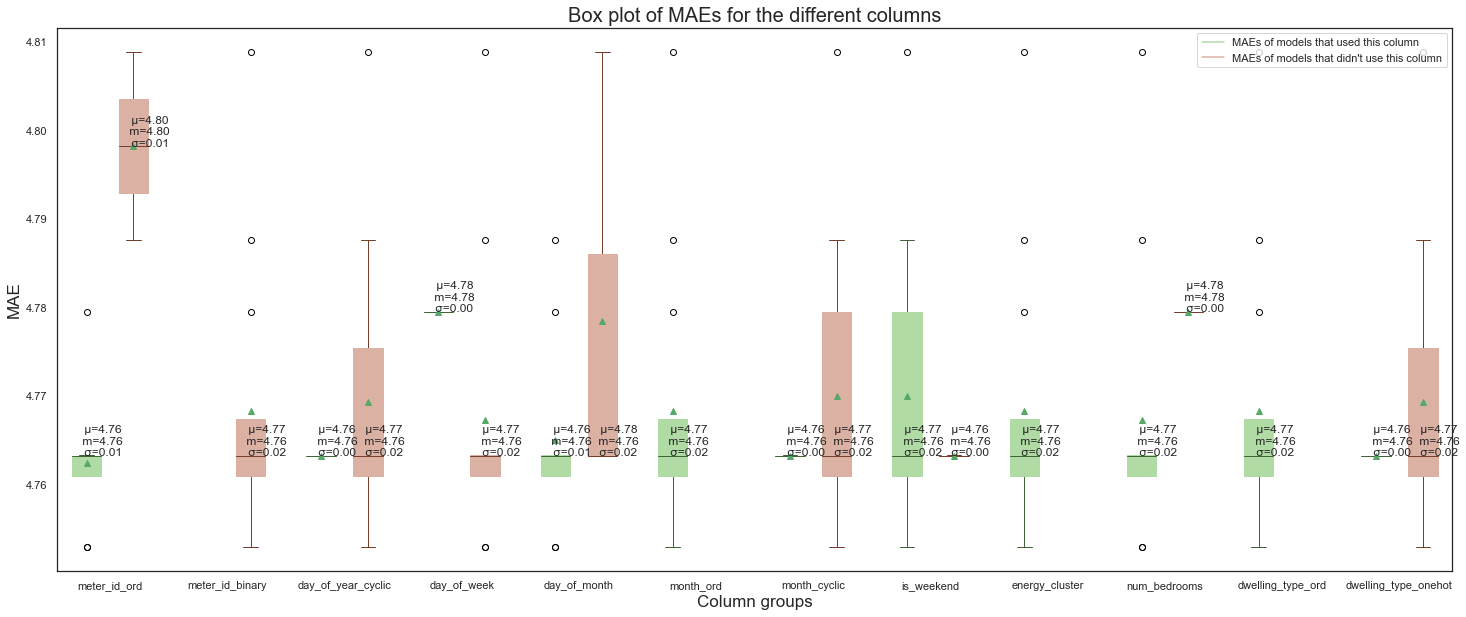

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


In [33]:
columns_maes = {} #dictionary of each columns maes
columnless_mae = {}
#iterating through each column and randomly decide whether or not to pick it
for key in tqdm(possible_columns.keys()):
    column = possible_columns[key][0] # only want to check against one column for the 'in'
    
    # if this column doesn't yet exist in the dict, create it
    if key not in columns_maes:
        columns_maes[key]=[]
    # if this column doesn't yet exist in the dict, create it
    if key not in columnless_mae:
        columnless_mae[key]=[]

    #iterating through every single models results
    for i in range(len(all_results)):
        
        #if this column was used by the model
        if column in all_results[i][1][0]:
            # adding this models mae to the dict entry for this column
            columns_maes[key].append(all_results[i][0][1])
            
        #else this column wasn't used by the model
        else:
            # adding this models mae to the dict entry for this column
            columnless_mae[key].append(all_results[i][0][1])

# print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}MAEs for each model which contains columns of each type{color.END}")
# pprint(columns_maes)

# function for setting the box colour
def set_box_color(bp, color_line, color_fill):
    plt.setp(bp['whiskers'], color=color_line)
    plt.setp(bp['caps'], color=color_line)
    plt.setp(bp['medians'], color=color_line)
    plt.setp(bp['fliers'], color=color_fill)
    plt.setp(bp['boxes'], color=color_fill)
    plt.setp(bp['means'], color=color_line)

    
### plotting a boxplot of these ###
# getting the 2 dicts we will plot
labels, data_columns = columns_maes.keys(), columns_maes.values()
data_columnless = columnless_mae.values()

#plotting these 2 dicts next to each other
fig = plt.figure(figsize=(25,10))
bp_dict_columns = plt.boxplot(data_columns,showmeans=True,positions=np.array(range(len(labels)))*2.0-0.4,patch_artist=True) # getting dictionary returned from boxplot
bp_dict_columnless = plt.boxplot(data_columnless,showmeans=True,positions=np.array(range(len(labels)))*2.0+0.4,patch_artist=True) # getting dictionary returned from boxplot

#colouring them
set_box_color(bp_dict_columns, '#416338','#b0dba4')
set_box_color(bp_dict_columnless, '#783d2b','#dbb1a4')

#annotating the plot
plt.title("Box plot of MAEs for the different columns", fontsize=20)
plt.xlabel("Column groups", fontsize=17)
plt.ylabel("MAE", fontsize=17)

#creating the legend
plt.plot([], c='#b0dba4',label="MAEs of models that used this column")
plt.plot([], c='#dbb1a4',label="MAEs of models that didn't use this column")
plt.legend()


## adding overlayed values to the boxplot

# stats for with columns
column_means = []
column_medians = []
column_std = []
for key in columns_maes.keys():
    column_means.append(np.mean(columns_maes[key]))
    column_medians.append(np.median(columns_maes[key]))
    column_std.append(np.std(columns_maes[key]))
for i, line in enumerate(bp_dict_columns['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n m={:.2f}\n σ={:.2f}'.format(column_means[i], column_medians[i], column_std[i])
    plt.text(x, y, text, horizontalalignment='center')
    
# stats for without columns
columnless_means = []
columnless_medians = []
columnless_std = []
for key in columnless_mae.keys():
    columnless_means.append(np.mean(columnless_mae[key]))
    columnless_medians.append(np.median(columnless_mae[key]))
    columnless_std.append(np.std(columnless_mae[key]))
for i, line in enumerate(bp_dict_columnless['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n m={:.2f}\n σ={:.2f}'.format(columnless_means[i], columnless_medians[i], columnless_std[i])
    plt.text(x, y, text, horizontalalignment='center')


plt.xticks(range(0, len(labels)*2,2), labels)

plt.show()

fig.savefig(f"..\\Results\\Genetic Algorithm\\Plots\\p{population_size}_g{number_of_generations}_Box_MAEs.png")

plt.close()

## Box and swarm plot to better inspect the distribution

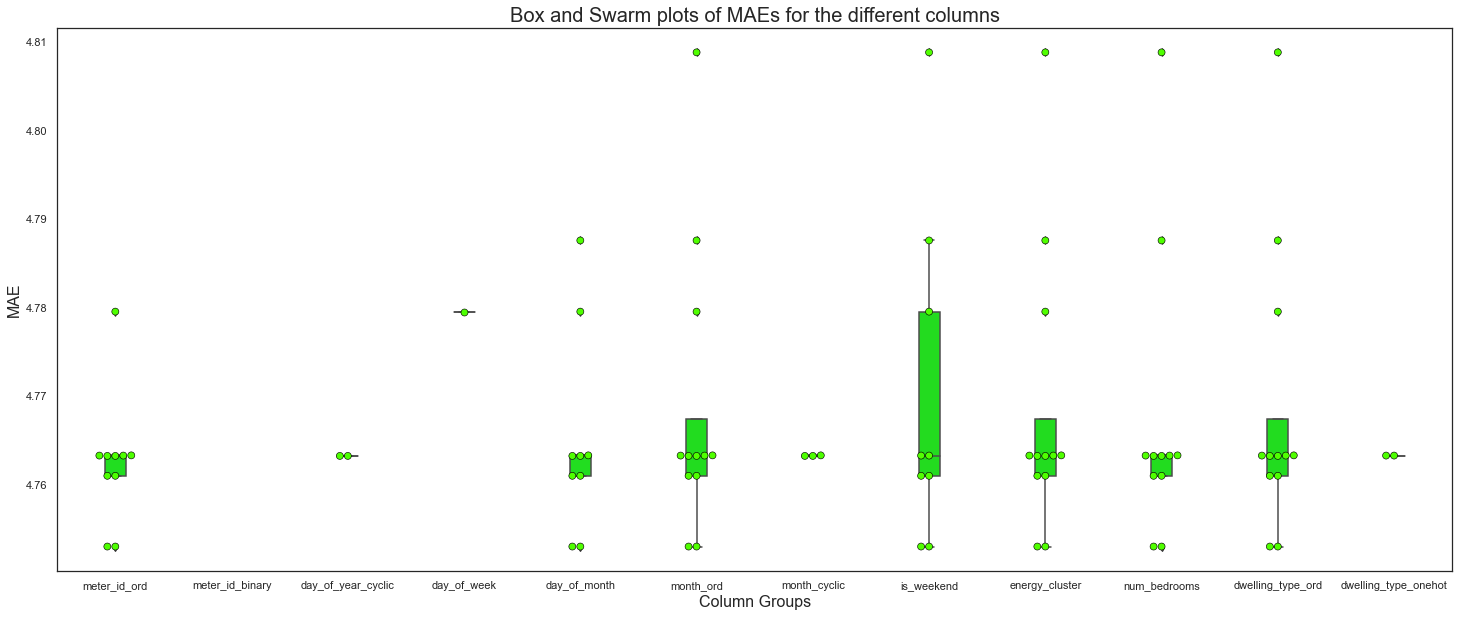

In [34]:
colourBlindFriendly = False # make graph colourBlindFriendly (pink to blue instead of red to green)

#gradient of green to red based on each columns stats
box_grad_palette = {}
for i in range(len(column_std)):
    box_grad_palette[i] = [column_std[i], 1-column_std[i],1 if colourBlindFriendly else 0] #based on std

fig=plt.figure(figsize=(25,10))
sns.set(context='notebook', style='white')
sns.utils.axlabel(xlabel="Column Groups", ylabel="MAE", fontsize=16)
sns.boxplot(data=list(data_columns), width=.18, palette=box_grad_palette)

#slightly paler gradient to make it stand out from the box
swarm_grad_palette = box_grad_palette.copy()
for i in range(len(swarm_grad_palette)):
    #fading it to white
    #adding to red to make it paler
    swarm_grad_palette[i][0] = swarm_grad_palette[i][0]+0.3 if swarm_grad_palette[i][0]+0.3<1 else 1
    #adding to green to make it paler
    swarm_grad_palette[i][1] = swarm_grad_palette[i][1]+0.3 if swarm_grad_palette[i][1]+0.3<1 else 1
    #adding to blue to make it paler
    if colourBlindFriendly:
        swarm_grad_palette[i][2] = swarm_grad_palette[i][2]+0.3 if swarm_grad_palette[i][2]+0.3<1 else 1


sns.swarmplot(data=list(data_columns), size=7, edgecolor="black", linewidth=.6, palette=swarm_grad_palette)

plt.xticks(plt.xticks()[0], labels)

plt.title("Box and Swarm plots of MAEs for the different columns", fontsize=20)

plt.show()
fig.savefig(f"..\\Results\\Genetic Algorithm\\Plots\\p{population_size}_g{number_of_generations}_BoxSwarm_MAEs_GRAD_STD.png")
plt.close()

### Main Effects Plots

  0%|          | 0/8 [00:00<?, ?it/s]

,learning_rate,MAE
0,0.07848,4.767308


[array([0.07848])]


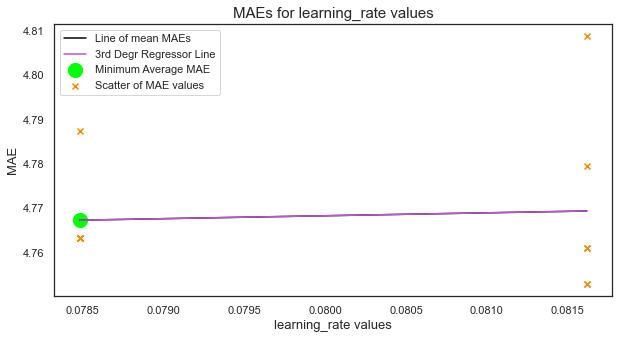

,num_leaves,MAE
0,53.0,4.763293


[array([0.07848]), array([53.])]


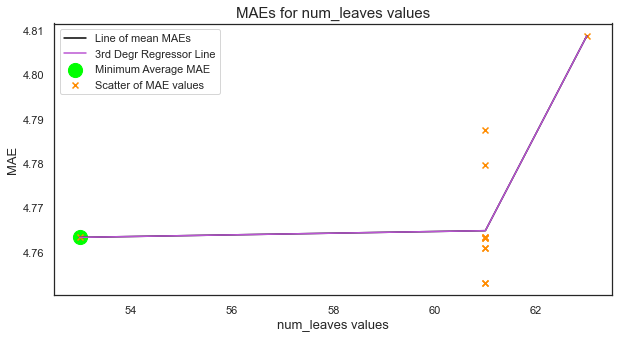

,max_depth,MAE
1,6.0,4.765485


[array([0.07848]), array([53.]), array([6.])]


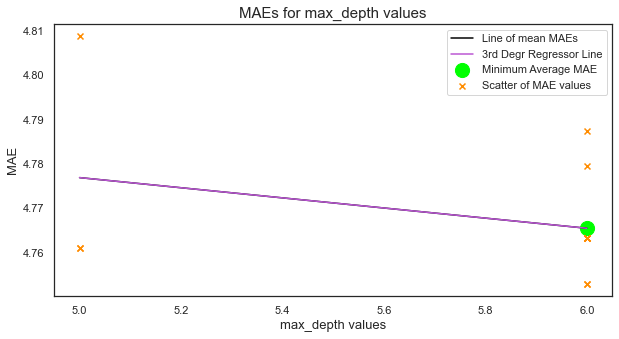

,bagging_fraction,MAE
0,0.551,4.767308


[array([0.07848]), array([53.]), array([6.]), array([0.551])]


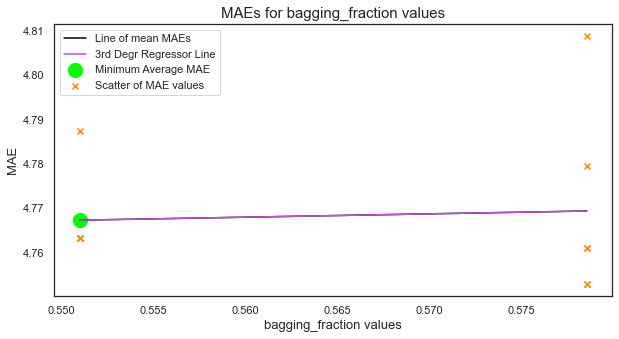

,bagging_freq,MAE
0,20.0,4.768344


[array([0.07848]), array([53.]), array([6.]), array([0.551]), array([20.])]


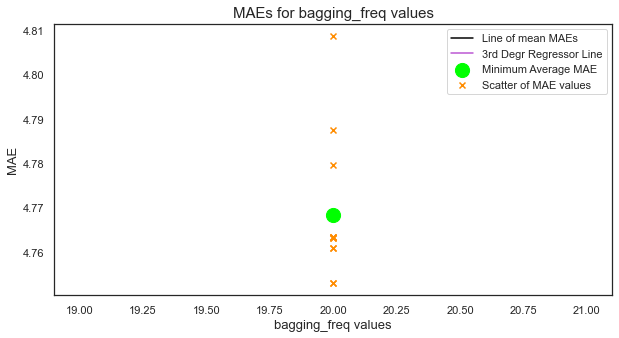

,feature_fraction,MAE
3,1.0,4.758136


[array([0.07848]), array([53.]), array([6.]), array([0.551]), array([20.]), array([1.])]


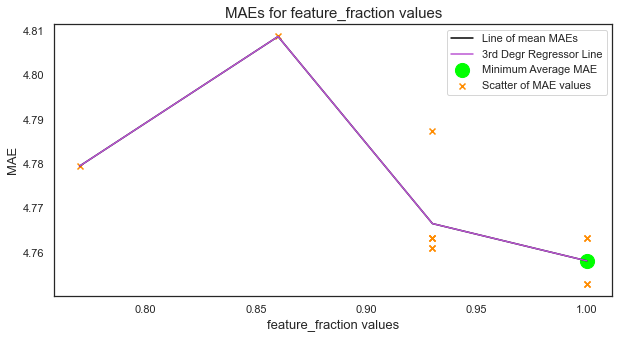

,lambda_l1,MAE
1,16.0,4.762397


[array([0.07848]), array([53.]), array([6.]), array([0.551]), array([20.]), array([1.]), array([16.])]


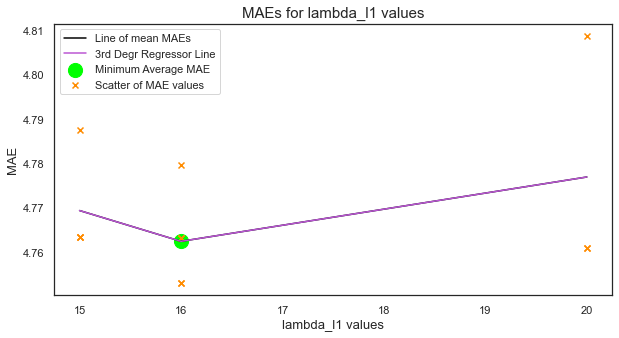

,lambda_l2,MAE
2,7.0,4.761995


[array([0.07848]), array([53.]), array([6.]), array([0.551]), array([20.]), array([1.]), array([16.]), array([7.])]


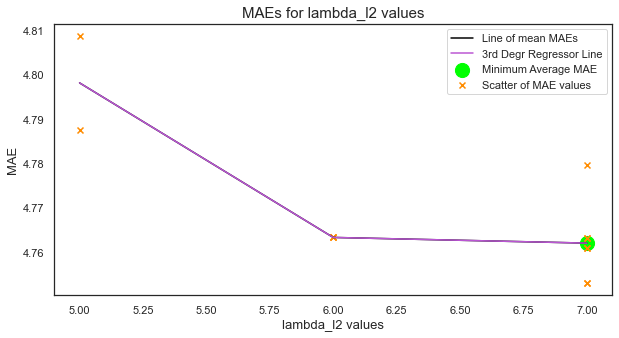

In [35]:
#array of the hyperparameters we tuned
arr_hypers = ["learning_rate","num_leaves","max_depth","bagging_fraction","bagging_freq","feature_fraction","lambda_l1","lambda_l2"]
arr_best_hypers = []
#iterate through each of these hypers
for hyper in tqdm(arr_hypers):

    df_max_depth = pd.DataFrame(columns = [hyper,"MAE"])

    #iterating through each column and randomly decide whether or not to pick it
    #iterating through every single models results
    for i in range(len(all_results)):
        # adding this models mae to the dict entry for this column
        df_max_depth.loc[i] = [all_results[i][1][1][hyper],all_results[i][0][1]]

    #sort in ascending order by the params values
    df_all = df_max_depth.sort_values(by=[hyper])
    # display(df_all)

    #grouping together by value and calculating mean
    grouped_df = df_all.groupby(hyper)
    mean_df = grouped_df.mean().reset_index()
    #display(mean_df)
    
    # the minimum point
    df_min = mean_df[mean_df['MAE']==mean_df['MAE'].min()]
    arr_best_hypers.append(df_min[hyper].values)
    display(df_min)

    #plotting the stats for this param 
    fig = plt.figure(figsize=(10,5))
    print(arr_best_hypers)
    
    plt.scatter(df_min[hyper], df_min.MAE, label="Minimum Average MAE", color="lime", marker="o",s=200)
    plt.plot(mean_df[hyper], mean_df.MAE, label="Line of mean MAEs", color="black") # line of means
    plt.scatter(df_all[hyper], df_all.MAE, label="Scatter of MAE values", color="darkorange", marker="x") # scatter of values
    plt.plot(np.unique(df_all[hyper]), 
             np.poly1d(np.polyfit(df_all[hyper], df_all.MAE, 3))
             (np.unique(df_all[hyper])), label="3rd Degr Regressor Line", color="mediumorchid") # line of best fit from a simple regressor

    plt.title(f"MAEs for {hyper} values", fontsize=15)
    plt.xlabel(f"{hyper} values", fontsize=13)
    plt.ylabel("MAE", fontsize=13)
    
    plt.legend()

    plt.show()
    fig.savefig(f"..\\Results\\Genetic Algorithm\\Plots\\p{population_size}_g{number_of_generations}_scatter_{hyper}.png")
    plt.close()

### inspecting stats on all models TOE and MAE

In [36]:
#inspecting the min/max/mean of time of execution of the models we tested in genetic algorithm
all_toes = []
all_maes = [] 

for i in range(len(all_results)):
    #getting the results for this model
    all_toes.append(all_results[i][0][0])
    all_maes.append(all_results[i][0][1])
    
print()
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}min time of execution = {color.END}{str(datetime.timedelta(seconds=round(min(all_toes))))}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}max time of execution = {color.END}{str(datetime.timedelta(seconds=round(max(all_toes))))}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}mean time of execution = {color.END}{str(datetime.timedelta(seconds=round(np.mean(all_toes))))}")
print()
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}min MAE = {color.END}{min(all_maes)}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}max MAE= {color.END}{max(all_maes)}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}mean MAE = {color.END}{np.mean(all_maes)}")


min time of execution = 0:00:05
max time of execution = 0:00:06
mean time of execution = 0:00:06

min MAE = 4.753002542946105
max MAE= 4.808780056155149
mean MAE = 4.768343698419826


## Inspecting the results of the hyper parameter optimization

In [37]:
best_index = 0
best_mae = 999999

for i in range(len(all_results)):
    #getting the results for this model
    LGBM_TOE = all_results[i][0][0]
    LGBM_MAE = all_results[i][0][1]
    #displaying the results
    print(f"{color.BOLD}{color.RED}{color.UNDERLINE}generation {int(i/population_size)} individual {i%population_size} {color.END}")
    print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:{color.END} {str(datetime.timedelta(seconds=round(LGBM_TOE)))}")
    print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {LGBM_MAE}")
    print("")
    
    #keeping track of the best performing model
    if(LGBM_MAE<best_mae):
        best_mae=LGBM_MAE
        best_index = i
print("best model is at generation",int(best_index/population_size),"individual",best_index%population_size,"with a MAE of",best_mae)

generation 0 individual 0 
Time of execution for skf-cv: 0:00:06
Mean absolute error between OOF preds and meter_reading on training set: 4.753002542946105

generation 0 individual 1 
Time of execution for skf-cv: 0:00:06
Mean absolute error between OOF preds and meter_reading on training set: 4.7632319042192055

generation 0 individual 2 
Time of execution for skf-cv: 0:00:06
Mean absolute error between OOF preds and meter_reading on training set: 4.763269799362754

generation 0 individual 3 
Time of execution for skf-cv: 0:00:06
Mean absolute error between OOF preds and meter_reading on training set: 4.763292780636303

generation 0 individual 4 
Time of execution for skf-cv: 0:00:05
Mean absolute error between OOF preds and meter_reading on training set: 4.787550157269412

generation 0 individual 5 
Time of execution for skf-cv: 0:00:06
Mean absolute error between OOF preds and meter_reading on training set: 4.760987570281793

generation 1 individual 0 
Time of execution for skf-cv: 

## Training a model based on the best models 
* Done this as no longer storing the models in memory as was running out
* So instead just storing the configuration
* Then this is used to retrain a model with that configuration
    * Should fix the problem of running out of memory whilst running the GA

In [44]:
best_X_cols = all_results[best_index][1][0]
best_X_cats = list(set(best_X_cols).intersection(all_cat)) #getting the categorical values for this X
best_params = all_results[best_index][1][1]
best_run = run_lgbm_skf_cv(False, False, SEED, num_folds, df_train.copy(), y_col, best_X_cols, best_X_cats, best_params)

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.5785499999999999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5785499999999999
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 4.7457
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warn

## Making predictions on best model

In [45]:
#making predictions based on the best performing model and displaying it's information
BEST_LGBM_MODELS = best_run[2] #getting the lgbm_models from the best index
BEST_LGBM_FORECASTS = df_preds.copy()
start_time = time.time() 

#calculating the average preds by summing the weighted preds for each folds model
for i in range(len(BEST_LGBM_MODELS)):
    pred_forecasts = BEST_LGBM_MODELS[i].predict(BEST_LGBM_FORECASTS[all_results[best_index][1][0]], num_iteration=BEST_LGBM_MODELS[i].best_iteration_) #predicting the unkown df_preds
    BEST_LGBM_FORECASTS[y_col] += pred_forecasts / num_folds #weighting the predictions for BEST_LGBM_FORECASTS for this fold and adding to df_preds y column 
BEST_LGBM_FORECASTS["meter_reading"] = BEST_LGBM_FORECASTS.meter_reading.clip(lower=0) #clip meter_reading so no predictions lower than 0
execution_time = time.time() - start_time

## Inspecting information on best model

In [46]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}best model came from generation {int(best_index/population_size)} individual {best_index%population_size}{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:  {color.END}{str(datetime.timedelta(seconds=round(all_results[best_index][0][0])))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for predictions: {color.END}{str(datetime.timedelta(seconds=round(execution_time)))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Total time of execution: {color.END}{str(datetime.timedelta(seconds=round(all_results[best_index][0][0]+execution_time)))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {all_results[best_index][0][1]}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}preds set with the next years forecasts for each meter{color.END}")
display(BEST_LGBM_FORECASTS[["meter_id","date","meter_reading"]])
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(all_results[best_index][1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(all_results[best_index][1][1])

best model came from generation 0 individual 0
Evaluation and results
Time of execution for skf-cv:  0:00:06

Time of execution for predictions: 0:00:01

Total time of execution: 0:00:07

Mean absolute error between OOF preds and meter_reading on training set: 4.753002542946105

preds set with the next years forecasts for each meter


,meter_id,date,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-01,8.950250
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-02,8.950250
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-03,8.950250
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-04,8.950250
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-05,8.950250
...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2018-12-27,10.464363
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2018-12-28,10.464363
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2018-12-29,10.464363
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2018-12-30,10.464363


Hyper-parameters

X_cols:

['meter_id_ord',
 'day_of_month',
 'month_ord',
 'is_weekend',
 'energy_cluster',
 'num_bedrooms',
 'dwelling_type_ord']
model params:  
{'bagging_fraction': 0.5785499999999999,
 'bagging_freq': 20,
 'boosting_type': 'gbdt',
 'feature_fraction': 1,
 'lambda_l1': 16,
 'lambda_l2': 7,
 'learning_rate': 0.08161919999999999,
 'max_depth': 6,
 'metric': 'mae',
 'num_iterations': 1,
 'num_leaves': 61,
 'num_threads': -1,
 'seed': 137}


## Saving the description of the best model

In [ ]:
BEST_LGBM_FORECASTS.to_pickle(f"..\\Results\\Genetic Algorithm\\p{population_size}_g{number_of_generations}_best_model_daily_forecasts.pkl")

In [ ]:
import pickle

desc_disc = {
    "time_of_execution_skf-cv":str(datetime.timedelta(seconds=round(all_results[best_index][0][0]))),
    "time_of_execution_preds":str(datetime.timedelta(seconds=round(execution_time))),
    "time_of_execution_total":str(datetime.timedelta(seconds=round(all_results[best_index][0][0]+execution_time))),
    "MAE":all_results[best_index][0][1],
    "features":all_results[best_index][1][0],
    "params":all_results[best_index][1][1]
}

with open(f"..\\Results\\Genetic Algorithm\\p{population_size}_g{number_of_generations}_best_model_desc.pkl", 'wb') as handle:
    pickle.dump(desc_disc, handle, protocol=pickle.HIGHEST_PROTOCOL)

pprint(desc_disc)
    
# verifying it saved correctly and can be loaded back
with open(f"..\\Results\\Genetic Algorithm\\p{population_size}_g{number_of_generations}_best_model_desc.pkl", 'rb') as handle:
    desc_disc_loaded = pickle.load(handle)
print(desc_disc == desc_disc_loaded)

# Converting into monthly forecasts

In [ ]:
#restructuring into the original multiple time series format
#aggregating up the total sum of the months predictions
df_monthly_forecasts = BEST_LGBM_FORECASTS.groupby(["meter_id", "month_ord"])["meter_reading"].sum().unstack()

#rename ordinal encoded month with its corresponding name
df_monthly_forecasts.rename(columns={1:"Jan", 2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}, inplace=True)
#resetting the index 
df_monthly_forecasts.reset_index(inplace=True)
df_monthly_forecasts.index.name = None # removing index column
df_monthly_forecasts.columns.name = None # removing columns name

display(df_monthly_forecasts)

## Saving these monthly predictions to be submitted to competition
* Saving predictions ready to be submitted so I can get the MAE on the test set

In [ ]:
df_monthly_forecasts.to_csv(f"..\\Results\\Genetic Algorithm\\p{population_size}_g{number_of_generations}_best_model_monthly_forecasts.csv", index=False, header=True)

# Plotting these monthly forecasts
## Renaming months to dates for plotting

In [ ]:
df_monthly_forecasts.rename(columns={"Jan":"2018-01", "Feb":"2018-02","Mar":"2018-03","Apr":"2018-04","May":"2018-05","Jun":"2018-06","Jul":"2018-07","Aug":"2018-08","Sep":"2018-09","Oct":"2018-10","Nov":"2018-11","Dec":"2018-12"}, inplace=True)
df_monthly_forecasts

## Restructuring forecasts into daily predictions to plot on top of monthly preds

In [ ]:
#daily forecasts to plot on top of monthly
df_daily_forecasts = BEST_LGBM_FORECASTS.groupby(["meter_id","date"])["meter_reading"].sum().unstack()

#resetting the index 
df_daily_forecasts.reset_index(inplace=True)
df_daily_forecasts.index.name = None # removing index column
df_daily_forecasts.columns.name = None # removing columns name

df_daily_forecasts

## loading training data and aggregating into months

In [ ]:
#loading the training data
print("training data")
df_train_daily = pd.read_pickle("../Data/Preprocessed_Data/consumption_daily_nan_interpolated.pkl").fillna(0)

#aggregating up into months
meter_id=df_monthly_forecasts["meter_id"]
df_train_monthly = pd.DataFrame(columns=["meter_id"])
df_train_monthly["meter_id"] = meter_id


#for each month in the range of dates
resample_size="M"
for new_sample in tqdm(pd.date_range(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31), freq = resample_size),position=0):

    #get this columns name as a string
    columnName = str(new_sample.date())[:7]
    #get all columns that relate to this new sample
    columns = [i for i in df_train_daily.columns.values[1:] if i.startswith(columnName)]

    #sum these up into a value for the new sample size
    df_train_monthly[columnName] = df_train_daily[columns].sum(axis=1)

display(df_train_daily)
display(df_train_monthly)

## Plotting the predictions against the training data

In [ ]:
for pid in tqdm(range(0,3248)):
    #getting the row corresponding to this meter_id
    meter_id = df_daily_forecasts.iloc[pid,0]
    this_train_month = df_train_monthly.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    this_preds_month = df_monthly_forecasts.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    this_train_day = df_train_daily.loc[df_train_daily['meter_id'] == meter_id].T[1:]
    this_preds_day = df_daily_forecasts.loc[df_daily_forecasts['meter_id'] == meter_id].T[1:]
    
    #converting index to datetime for ease of plots key
    this_train_month.index=pd.to_datetime(this_train_month.index)
    this_preds_month.index=pd.to_datetime(this_preds_month.index)
    this_train_day.index=pd.to_datetime(this_train_day.index)
    this_preds_day.index=pd.to_datetime(this_preds_day.index)
    
    #creating figure
    fig = plt.figure(figsize=(20,20))
    
    #plotting the monthly predictions
    plt.subplot(2,1,1)
    plt.title("Meter '"+str(meter_id)+"' monthly forecasts and historical data", fontsize=15)
    plt.xlabel("Date")
    plt.ylabel("Energy Usage kWh")
    plt.plot(this_train_month, label="training monthly energy", lw=1,color="skyblue", marker="x")
    plt.plot(this_preds_month, label="forecast monthly energy", lw=1,color="mediumorchid", marker="x")
    
    
    #plotting the daily predictions
    plt.subplot(2,1,2)
    plt.title("Meter '"+str(meter_id)+"' daily forecasts and historical data", fontsize=15)
    plt.xlabel("Date")
    plt.ylabel("Energy Usage kWh")
    plt.plot(this_train_day, label="training daily energy", lw=1,color="skyblue")
    plt.plot(this_preds_day, label="forecast daily energy", lw=1,color="mediumorchid")

    #annotations
    plt.legend(fontsize=20)
    plt.locator_params(nbins=24)
    
    #plt.show()

    fig.savefig(f"..\\Results\\Genetic Algorithm\\Plots\\forecasts\\p{population_size}_g{number_of_generations}_forecasts_{pid}_{meter_id}.png")

    plt.close()

# Training a model based on the main effects
* Running on the hyper params determined by main effects (setting that gave the lowest mean result)

In [ ]:
# treating columns like main effects: accepting those whose mean error with the column is better than that without the column
main_columm_types = []
i=0
for key in possible_columns.keys():
    print(key,column_means[i]<columnless_means[i])
    main_columm_types.append(key)
    i+=1 
print(main_columm_types)

In [ ]:
#inspecting the stored best values for each hyper as determined by the main effects plot
#(value which resulted in the lowest average MAE on the val set)
print(arr_hypers)
print(arr_best_hypers) 

In [ ]:
start_time = time.time()
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}Running with main effects determined configuration{color.END}")

print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Using the features{color.END}")
X_cols =[]

for key in main_columm_types:
    X_cols+=(possible_columns[key])
this_X_cats = list(set(X_cols).intersection(all_cat)) #getting the categorical values for this X
print(X_cols)

print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Using the main effects hyper parameters{color.END}")
this_params = params.copy()
this_params["learning_rate"] = arr_best_hypers[0][0]
this_params["max_depth"] = int(arr_best_hypers[2][0])
this_params["num_leaves"] = int(arr_best_hypers[1][0])
this_params["bagging_fraction"] = arr_best_hypers[3][0]
this_params["bagging_freq"] = int(arr_best_hypers[4][0])
this_params["feature_fraction"] = arr_best_hypers[5][0]
this_params["lambda_l1"] = int(arr_best_hypers[6][0])
this_params["lambda_l2"] = int(arr_best_hypers[7][0])
pprint(this_params)

#train the model with this hyper param config and store it's results
results=((run_lgbm_skf_cv(False, False, SEED, num_folds, df_train.copy(), y_col, X_cols, this_X_cats, this_params),(X_cols,this_params)))
print("\n\n\n")
time_of_execution = time.time()-start_time
print(f"{color.BOLD}Trained the model in {str(datetime.timedelta(seconds=round(time_of_execution)))}{color.END}\n")

# Forecasting from the main effects model

In [ ]:
#making predictions based on the best performing model and displaying it's information
main_effects_models = results[0][2] #getting the lgbm_models from the best index
main_effects_forecasts = df_preds.copy()

#calculating the average preds by summing the weighted preds for each folds model
for i in range(len(main_effects_models)):
    pred_forecasts = main_effects_models[i].predict(main_effects_forecasts[results[1][0]], num_iteration=main_effects_models[i].best_iteration_) #predicting the unkown df_preds
    main_effects_forecasts[y_col] += pred_forecasts / num_folds #weighting the predictions for BEST_LGBM_FORECASTS for this fold and adding to df_preds y column 
main_effects_forecasts["meter_reading"] = main_effects_forecasts.meter_reading.clip(lower=0) #clip meter_reading so no predictions lower than 0

display(main_effects_forecasts)

# Comparing the val error of the main effects vs the best from genetic algorithm tuning
## Genetic Algorithm summary

In [ ]:
best_index

In [ ]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}GA best model came from generation {int(best_index/population_size)} individual {best_index%population_size}{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {all_results[best_index][0][1]}\n")
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(all_results[best_index][1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(all_results[best_index][1][1])

## Main effects based model summary

In [ ]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}Main effects model based on results of GA {int(best_index/population_size)}|{best_index%population_size}{color.END}{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {results[0][1]}\n")
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(results[1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(results[1][1])

#### TODO Conclusion


# Save the main effects description

In [ ]:
import pickle

a = {'hello': 'world'}
desc_disc = {
    "MAE":results[0][1],
    "features":results[1][0],
    "params":results[1][1]
}

with open(f"..\\Results\\Genetic Algorithm\\p{population_size}_g{number_of_generations}_main_effects_desc.pkl", 'wb') as handle:
    pickle.dump(desc_disc, handle, protocol=pickle.HIGHEST_PROTOCOL)

pprint(desc_disc)
    
# verifying it saved correctly and can be loaded back
with open(f"..\\Results\\Genetic Algorithm\\p{population_size}_g{number_of_generations}_main_effects_desc.pkl", 'rb') as handle:
    desc_disc_loaded = pickle.load(handle)
print(desc_disc == desc_disc_loaded)

# Formatting the main effects forecasts and saving them

# Converting into monthly forecasts

In [ ]:
#restructuring into the original multiple time series format
#aggregating up the total sum of the months predictions
df_monthly_forecasts = main_effects_forecasts.groupby(["meter_id", "month_ord"])["meter_reading"].sum().unstack()

#rename ordinal encoded month with its corresponding name
df_monthly_forecasts.rename(columns={1:"Jan", 2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}, inplace=True)
#resetting the index 
df_monthly_forecasts.reset_index(inplace=True)
df_monthly_forecasts.index.name = None # removing index column
df_monthly_forecasts.columns.name = None # removing columns name

display(df_monthly_forecasts)

## Saving these monthly predictions to be submitted to competition
* Saving predictions ready to be submitted so I can get the MAE on the test set

In [ ]:
df_monthly_forecasts.to_csv(f"..\\Results\\Genetic Algorithm\\p{population_size}_g{number_of_generations}_main_effects_monthly_forecasts.csv", index=False, header=True)

# Plotting these monthly forecasts
## Renaming months to dates for plotting

In [ ]:
df_monthly_forecasts.rename(columns={"Jan":"2018-01", "Feb":"2018-02","Mar":"2018-03","Apr":"2018-04","May":"2018-05","Jun":"2018-06","Jul":"2018-07","Aug":"2018-08","Sep":"2018-09","Oct":"2018-10","Nov":"2018-11","Dec":"2018-12"}, inplace=True)
df_monthly_forecasts

## Restructuring forecasts into daily predictions to plot on top of monthly preds

In [ ]:
#daily forecasts to plot on top of monthly
df_daily_forecasts = main_effects_forecasts.groupby(["meter_id","date"])["meter_reading"].sum().unstack()

#resetting the index 
df_daily_forecasts.reset_index(inplace=True)
df_daily_forecasts.index.name = None # removing index column
df_daily_forecasts.columns.name = None # removing columns name

df_daily_forecasts

## loading training data and aggregating into months

In [ ]:
#loading the training data
print("training data")
df_train_daily = pd.read_pickle("../Data/Preprocessed_Data/consumption_daily_nan_interpolated.pkl").fillna(0)

#aggregating up into months
meter_id=df_monthly_forecasts["meter_id"]
df_train_monthly = pd.DataFrame(columns=["meter_id"])
df_train_monthly["meter_id"] = meter_id


#for each month in the range of dates
resample_size="M"
for new_sample in tqdm(pd.date_range(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31), freq = resample_size),position=0):

    #get this columns name as a string
    columnName = str(new_sample.date())[:7]
    #get all columns that relate to this new sample
    columns = [i for i in df_train_daily.columns.values[1:] if i.startswith(columnName)]

    #sum these up into a value for the new sample size
    df_train_monthly[columnName] = df_train_daily[columns].sum(axis=1)

display(df_train_daily)
display(df_train_monthly)

## Plotting the predictions against the training data

In [ ]:
for pid in tqdm(range(0,3248)):
    #getting the row corresponding to this meter_id
    meter_id = df_daily_forecasts.iloc[pid,0]
    this_train_month = df_train_monthly.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    this_preds_month = df_monthly_forecasts.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    this_train_day = df_train_daily.loc[df_train_daily['meter_id'] == meter_id].T[1:]
    this_preds_day = df_daily_forecasts.loc[df_daily_forecasts['meter_id'] == meter_id].T[1:]
    
    #converting index to datetime for ease of plots key
    this_train_month.index=pd.to_datetime(this_train_month.index)
    this_preds_month.index=pd.to_datetime(this_preds_month.index)
    this_train_day.index=pd.to_datetime(this_train_day.index)
    this_preds_day.index=pd.to_datetime(this_preds_day.index)
    
    #creating figure
    fig = plt.figure(figsize=(20,20))
    
    #plotting the monthly predictions
    plt.subplot(2,1,1)
    plt.title("Meter '"+str(meter_id)+"' monthly forecasts and historical data", fontsize=15)
    plt.xlabel("Date")
    plt.ylabel("Energy Usage kWh")
    plt.plot(this_train_month, label="training monthly energy", lw=1,color="skyblue", marker="x")
    plt.plot(this_preds_month, label="forecast monthly energy", lw=1,color="mediumorchid", marker="x")
    
    
    #plotting the daily predictions
    plt.subplot(2,1,2)
    plt.title("Meter '"+str(meter_id)+"' daily forecasts and historical data", fontsize=15)
    plt.xlabel("Date")
    plt.ylabel("Energy Usage kWh")
    plt.plot(this_train_day, label="training daily energy", lw=1,color="skyblue")
    plt.plot(this_preds_day, label="forecast daily energy", lw=1,color="mediumorchid")

    #annotations
    plt.legend(fontsize=20)
    plt.locator_params(nbins=24)
    
    #plt.show()

    fig.savefig(f"..\\Results\\Genetic Algorithm\\Plots\\forecasts\\main_effects\\p{population_size}_g{number_of_generations}_forecasts_{pid}_{meter_id}.png")

    plt.close()